This notebook makes it possible to detect which trapaziodal region a point is on a plane in O(Log(N)) time. The underlining data structure used is a Segment Tree. A Segment Tree is a balanced binary tree in which each node directs down to a child node allowing for speedy traversal.  

This is how it works:
1. In each polygonal section of a 2d graph, a region is marked as r(k)
2. Then at each vertex of the graph, a vertical line is drawn spanning the entire plane.
3. These vertical lines split the graph into "segments" where each segment contains a stack of edges that do not intersect
4. A preliminary segment tree is constructed which stores the range of each segment on the x-axis as an array of leaf nodes
5. The parent nodes of this preliminary tree store the total range of their children
6. We can traverse this tree by comparing the x value of our query point to the midpoint. If less than we go to the left, else we go to the right.
7. Once we reach a leaf note we then traverse through a sub segment tree which stores all of the edges in a given segment
8. We then traverse through the sub tree by comparing our query point the middle edge and determining if it is above or below.
9. Finaly we reach a sub tree leaf node 
10. This node stores an edge in a segment and, more importantly, the region above it which tells us which region a query point is in.

In [1]:
import shapely
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import random


from shapely.geometry import Polygon, LineString

In [2]:
def randPoly(points):
    
    while True:
    
        coor = [(random.uniform(0,100000), random.uniform(0,100000)) for _ in range(points)]

        coor.append(coor[0])


        p1 = Polygon(coor)

        if all(not p1.intersects(p2) for p2 in polygons):
                polygons.append(p1)

                return p1

---- NODES ----

In [3]:
class Node(object):
    
    def __init__(self, value):
        # value should be tuple
        self.v = value
        # left child of node
        self.lc = None
        # right child of node
        self.rc = None
        # parent of node
        self.p = None
        
    def evaluatePoint(self, x, y, comps = 0):
        comps += 1
        # Traverse tree until reaching a leaf node. 
        if self.lc is None:
            # Now traverse subtree
            return self.subtree.evaluatePoint(x,y, comps)
        
        # QUESTION FOR CORY: what to do if we have point which is on an 
        # edge, vertex, or vertical line
        if self.midpoint() >= x:
            return self.lc.evaluatePoint(x,y, comps)
        elif self.rc is not None:
            return self.rc.evaluatePoint(x,y, comps)
        else:
            return (None, comps)
        
    # to create a parent node, add the range of lc to rc
    def calculate(self):
        if self.lc is not None:
            self.v = self.lc.v
        if self.rc is not None:
            self.v = (self.v[0], self.rc.v[1])
        # recursivly update tree
        if self.p is not None:
            self.p.calculate()
            
    def midpoint(self):
        return (self.v[0] + self.v[1]) / 2
    

In [4]:
# Leaf node for the primary tree
class L_Node(Node):
    
    def __init__(self, chords, subtree):
        
        super().__init__(chords)
        
        # Subtree is another Segment Tree that calculates region which the point resides
        self.subtree = subtree
    

In [5]:
# This method is re-used in testing so I brought it out
def pointBelowEdge(v1, v2, x, y):
    # Calculate if the point is below the edge
        # Calculate the slope of edge
        m = (v2[1] - v1[1]) / (v2[0] - v1[0])

        # Calculate the y-intercept from p1
        b = v1[1] - m * v1[0]

        # At x, where is the edge?
        edge_at_x = m * x + b

        # Check if y is below the edge at x
        return y < edge_at_x
    

# Sub Tree Parent node
class SP_Node(Node):
    
    def evaluatePoint(self, x, y, comps):
        comps += 1
        
        # Check if leaf node
        if self.lc is None:
            print("SEGMENT")
            return (self.r, comps)
        
        if pointBelowEdge(self.v[0], self.v[1], x, y):
            return self.lc.evaluatePoint(x,y, comps)
        elif self.rc is not None:
            return self.rc.evaluatePoint(x,y, comps)
        else:
            return (None, comps)
        
    
    def calculate(self):
        # check if node has a right child
        if self.rc is not None:
            # check if right child has a left child
            if self.rc.lc is not None:
                # set value of node to the left child of right child.
                # This esentualy finds the midpoint in a segment
                self.v = self.rc.lc.v
            else:
                # if no right child must be a layer 1 node 
                self.v = self.rc.v
        else:
            # must only have lc but must be parent bc of class
            # node will be a coppy of its left child
            self.v = self.lc.v

In [6]:
# Leaf node for the secondary segment tree or "sub trees"
class SL_Node(SP_Node):
    
    def __init__(self, p1, p2, region):
        
        super().__init__((p1,p2))
        
        # store the region immediately above the edge
        self.r = region
    

---- SEGMENT TREES ----

In [7]:
# The primary Segment Tree class is for the purpose of finding the "segment" or 
# region on the x axis where a specific point resides. Leaf nodes in this
# tree store a range of x values and a subtree to find the 2d region where the
# point resides.
class SegmentTree():
    
    def __init__(self, arr):
        # In order to create 
        self.leaves = arr
        self.root = None
        self.build()
        
    def allLeaves(self):
        return [i.v for i in self.leaves]
    
    def evaluatePoint(self,x,y, comps = 0):
        if self.root is not None:
            res = self.root.evaluatePoint(x,y,comps)
            if res[0] is not None:
                return res
            else:
                return (None, comps)
        else:
            print("no root")
        
    def build(self):
        layer = self.leaves
        #loop through each layer of tree
        while len(layer) > 1:
            
            next_layer = []

            for i in range(0,len(layer), 2):
                # create new parent node
                parent = Node(layer[i].v)
                # assign left child
                parent.lc = layer[i]
                
                if len(layer) > i + 1:
                    # assign right child and recompute sum
                    parent.rc = layer[i + 1]
                    parent.calculate()
                    layer[i + 1].p = parent

                layer[i].p = parent
                
                # move to next layer
                next_layer.append(parent)
                
            layer = next_layer
        
        self.root = layer[0]
        

In [8]:
# The secondary segment tree or "sub tree" is responsible for evaluating
# which region which a given point is in on the y axis
class SubTree(SegmentTree):
    
    def build(self):
        layer = self.leaves
        #loop through each layer of tree
        while len(layer) > 1:
            
            next_layer = []

            for i in range(0,len(layer), 2):
                # create new parent node
                parent = SP_Node(layer[i].v)
                # assign left child
                parent.lc = layer[i]
                
                if len(layer) > i + 1:
                    # assign right child and recompute sum
                    parent.rc = layer[i + 1]
                    parent.calculate()
                    layer[i + 1].p = parent

                layer[i].p = parent
                
                # move to next layer
                next_layer.append(parent)
                
            layer = next_layer
        self.root = layer[0]

In [9]:
# class for testing that overrides all the segment tree stuff and just loops through arrays
class JustArrays(SegmentTree):
    
    def evaluatePoint(self, x, y):
        
        comps = 0
        
        # loop through all segments
        for segment in self.leaves:
            comps += 1
            if x < segment.v[1] and x > segment.v[0]:
                # loop through all edges in segment starting at top instead of bottom
                for edge in segment.subtree.leaves[::-1]:
                    comps += 1
                    if not pointBelowEdge(edge.v[0],edge.v[1], x, y):
                        print("JUST ARRAYS")
                        return (edge.r, comps)
                
    
    def build(self):
        pass
        

---- SPLITTING METHOD ----

In [10]:
class Poly():
    
    def __init__(self, poly, region):
        self.p = poly
        self.r = region
        # Get all the edges
        b = poly.boundary.coords
        self.edges = [(b[k:k+2]) for k in range(len(b) - 1)]
        self.calculate()
        
    def calculate(self):
        # Modify the edges by switching points if necessary
        modified_edges = []
        for coords in self.edges:
            if coords[0][0] > coords[1][0]:
                coords[0], coords[1] = coords[1], coords[0]
            modified_edges.append(coords)

        # Sort the modified edges
        sorted_edges = sorted(modified_edges, key=lambda edge: (edge[0][0], edge[0][1], edge[1][1]))
        
        # Extract the unique vertices
        vertices = set()
        for edge in sorted_edges:
            vertices.update(edge)

        # Convert the vertices set to a list and sort it by x and y values
        self.vertices = sorted(vertices, key=lambda vertex: (vertex[0], vertex[1]))
        
        # Remove the vertical edges as they are not needed
        self.edges = [edge for edge in sorted_edges if edge[0][0] != edge[1][0]]
        
    def allEdges(self):
        # Label each edge with the region above it
        labels = [self.r if i % 2 == 0 else None for i in range(len(self.edges))]
        return [edge + [label] for edge, label in zip(self.edges, labels)]

    def split(self,points):
        will_split = []
        
        for x in points:
            for i in range(len(self.edges)):
                if self.edges[i][0][0] < x and self.edges[i][1][0] > x:
                    will_split.append((i,x))

        i = 0
        while len(will_split) > 0:
            edge = will_split.pop(0)
            idx = edge[0] + i
            p1 = self.edges[idx][0]
            p2 = self.edges[idx][1]
            
            if p2[0] - p1[0] == 0:
                m = 0
            else:
                m = (p2[1] - p1[1]) / (p2[0] - p1[0])

            # Calculate the y-intercept from p1
            b = p1[1] - m * p1[0]

            # At x, where is the edge?
            y = m * edge[1] + b

            # split edge at x
            # print(self.edges[i][0])
            self.edges[idx] = [p1,(edge[1], y)]
            self.edges.insert(idx+1, [(edge[1], y), p2])
            
            i += 1
        
        self.calculate()




---- PERFORMANCE ANALYSIS ----

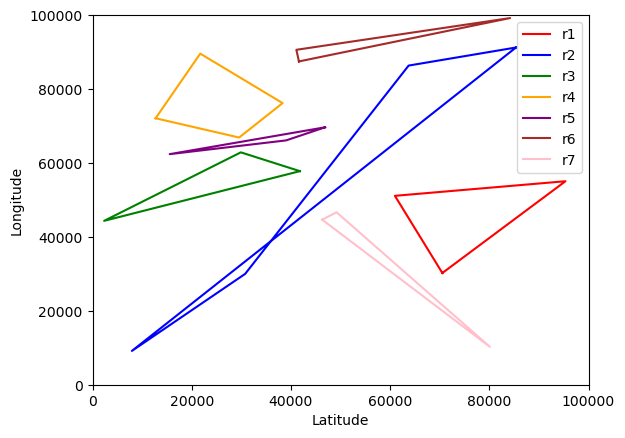

In [20]:

polygons = []

#----------------------------------------------------------------------------
fig, ax = plt.subplots()

#you can change the num of points here and add more shapes
poly1 = randPoly(3)
poly2 = randPoly(4)
poly3 = randPoly(3)
poly4 = randPoly(4)
poly5 = randPoly(3)
poly6 = randPoly(3)
poly7 = randPoly(3)


x1, y1 = poly1.exterior.xy
x2, y2 = poly2.exterior.xy
x3, y3 = poly3.exterior.xy
x4, y4 = poly4.exterior.xy
x5, y5 = poly5.exterior.xy
x6, y6 = poly6.exterior.xy
x7, y7 = poly7.exterior.xy

ax.plot(x1, y1, label='r1', color='red')
ax.plot(x2, y2, label='r2', color='blue')
ax.plot(x3, y3, label='r3', color='green')
ax.plot(x4, y4, label='r4', color='orange')
ax.plot(x5, y5, label='r5', color='purple')
ax.plot(x6, y6, label='r6', color='brown')
ax.plot(x7, y7, label='r7', color='pink')

# x and y lables
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

#legend different districts here
ax.legend()

#limits for the x axis
ax.set_xlim(0, 100000)
ax.set_ylim(0, 100000)

counter = 0

polys = []
vertices = []

# sort polygons from left to right
def leftmost_x(polygon):
    return polygon.bounds[0]

polygons = sorted(polygons, key=leftmost_x)

#Create an item of poly items
for polygon in polygons:
    counter+=1
    poly = Poly(polygon,"r"+str(counter))
    polys.append(poly)
    vertices += [p[0] for p in poly.vertices]
    
for poly in polys:
    poly.split(vertices)
    
edges =[]
for poly in polys:
    edges+= poly.allEdges()

edges = sorted(edges, key=lambda edge: (edge[0][0], edge[0][1], edge[1][1]))
vertices.sort()
segments = []
for i in range(len(vertices)):
    if len(vertices) > i:
        filtered_edges = [edge for edge in edges if edge[0][0] == vertices[i]]
        if len(filtered_edges) > 0:
            subtree = SubTree([SL_Node(edge[0],edge[1],edge[2]) for edge in filtered_edges])
            segments.append(L_Node((vertices[i],vertices[i + 1]), subtree))

In [21]:
# Feel free to play around with this! There are a lot of bugs but occasionaly it works right :)

st = SegmentTree(segments)
print(st.evaluatePoint(20000,40000))

test = JustArrays(segments)
print(test.evaluatePoint(20000,40000))

SEGMENT
(None, 0)
JUST ARRAYS
(None, 15)
